<a href="https://www.kaggle.com/code/baotranquoc685/mnist?scriptVersionId=195763297" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Advance Version of Neural Network -- MNIST
### Goal: Predict the number written in the 28x28 pixel image

### The model has the following specs:
- The first layer is the input layer, with size 784
- Then, there are three hidden layers,
  - The first hidden layer has 256 neurons, using Swish activation function
  - The second hidden layer has 32 neurons, using ReLU activation function
  - The third hidden layer has 10 neurons, using Softmax activation function
- Then, here comes the output.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
data = np.array(data)

## 1. Manipulate and normalize the data

### Here, we split the data into two sets:
  - The first set is for training purposes, where we train the model using the above neural network
  - The second set is for development purposes, where we test the accuracy of the model

In [2]:
m, n = data.shape
print(f"The data is {m} x {n}")
np.random.shuffle(data)

data_dev_length = 10000

# dev sev
data_dev = data[0:data_dev_length]
Y_dev =  data_dev[:, [0]] # (m x 1) matrix
X_dev = data_dev[:, 1:] # (m x 784) matrix
X_dev = X_dev / 255. # normalize the X

# train set
data_train = data[data_dev_length:]
Y_train = data_train[:, [0]] # (m x 1) matrix
X_train = data_train[:, 1:] # (m x 784) matrix
X_train = X_train / 255.

The data is 42000 x 785


## 2. Init params and functions

In [3]:
# X is (m x 784)
# Y is (m x 1)
def init_params():
  def xavier_init(n_in, n_out):
    limit = np.sqrt(6 / (n_in + n_out))
    return np.random.uniform(-limit, limit, (n_in, n_out))
  
  def he_init(n_in, n_out):
    return np.random.randn(n_in, n_out) * np.sqrt(2. / n_in)

  W1 = xavier_init(784, 256)
  b1 = np.zeros((1, 256))
  W2 = he_init(256, 32) # work better with ReLU
  b2 = np.zeros((1, 32))
  W3 = xavier_init(32, 10)
  b3 = np.zeros((1, 10))
  return W1, b1, W2, b2, W3, b3

def Sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

def Swish(Z):
  return Z * Sigmoid(Z)

def Swish_derivative(Z):
  sigmoid_Z = Sigmoid(Z)
  return sigmoid_Z + Z * sigmoid_Z * (1 - sigmoid_Z)

def ReLU(Z):
  return np.maximum(0, Z)

def ReLU_derivative(Z):
  return Z > 0

def Softmax(Z):
  max_Z = np.max(Z, axis=1, keepdims=True) # find the maximum element in each row, yield a (m x 1) matrix
  shift_Z = Z - max_Z
  exp_Z = np.exp(shift_Z)
  sum_Z = np.sum(exp_Z, axis=1, keepdims=True) # sum over the elements in each row, yield a (m x 1) matrix
  return exp_Z / sum_Z

def one_hot(Y):
  m, _ = Y.shape
  array_Y = Y.T[0] # convert Y to an array of size m
  one_hot = np.zeros((m, 10))
  one_hot[np.arange(m), array_Y] = 1
  return one_hot

def get_prediction(A):
  return np.argmax(A, axis=1)

def get_accuracy(prediction, Y):
  m, _ = Y.shape
  array_Y = Y.T[0]
  one_hot = np.zeros((m, 10))
  return np.sum(prediction == array_Y) / m

## 3. Neural Network -- Forward Propagation -- Backward Propagation

### Here, we put all the parameters used in the model in a class (OOP):
  - W1 := 784 x 256
  - b1 := 1 x 256
  - W2 := 256 x 32
  - b2 := 1 x 32
  - W3 := 32 x 10
  - b3 := 1 x 10

In [4]:
class Advance_Neural_Network:
  def __init__(self, alpha, decay_rate, iterations, batch_size):
    self.alpha = alpha
    self.decay_rate = decay_rate
    self.iterations = iterations
    self.batch_size = batch_size
    self.W1, self.b1, self.W2, self.b2, self.W3, self.b3 = init_params()

  def forward_prop(self, X):
    # layer 1
    Z1 = np.dot(X, self.W1) + self.b1
    A1 = ReLU(Z1)
    # layer 2
    Z2 = np.dot(A1, self.W2) + self.b2
    A2 = ReLU(Z2)
    # layer 3
    Z3 = np.dot(A2, self.W3) + self.b3
    A3 = Softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

  def backward_prop(self, Z1, A1, Z2, A2, Z3, A3, X, Y):
    m, _ = Y.shape
    # layer 3
    one_hot_Y = one_hot(Y)
    dZ3 = (A3 - one_hot_Y) / m
    dW3 = np.dot(A2.T, dZ3)
    db3 = np.sum(dZ3, axis=0, keepdims=True)
    # layer 2
    dZ2 = np.dot(dZ3, self.W3.T) * ReLU_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    # layer 1
    dZ1 = np.dot(dZ2, self.W2.T) * ReLU_derivative(Z1)
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)
    return dW1, db1, dW2, db2, dW3, db3

  def update_params(self, dW1, db1, dW2, db2, dW3, db3):
    self.W1 -= self.alpha * dW1
    self.b1 -= self.alpha * db1
    self.W2 -= self.alpha * dW2
    self.b2 -= self.alpha * db2
    self.W3 -= self.alpha * dW3
    self.b3 -= self.alpha * db3
  
  def mini_batch_gradient_descent(self, X, Y):
    # we will use a technic called mini-batch gradient descent
    # we will randomly pick a batch of 64
    number_of_samples, _ = X.shape
    last_accuracy = 1e15 # init to a small number
    for i in range(self.iterations):
      # get a random permutation
      permutation = np.random.permutation(number_of_samples)
      X_shuffle = X[permutation] # shuffle X
      Y_shuffle = Y[permutation] # shuffle Y
      # loop
      for j in range(0, number_of_samples, self.batch_size):
        # get the batch_size batch
        X_batch = X_shuffle[j:j + self.batch_size]
        Y_batch = Y_shuffle[j:j + self.batch_size]
        # perform ml
        Z1, A1, Z2, A2, Z3, A3 = self.forward_prop(X_batch)
        dW1, db1, dW2, db2, dW3, db3 = self.backward_prop(Z1, A1, Z2, A2, Z3, A3, X_batch, Y_batch)
        self.update_params(dW1, db1, dW2, db2, dW3, db3)
      # print the result every 50th iterations
      if (i % 5 == 0):
        _, _, _, _, _, A = self.forward_prop(X)
        print(f"Iteration: {i}")
        prediction = get_prediction(A)
        accuracy = get_accuracy(prediction, Y)
        print(f"Accuracy: {accuracy}")
        # stop when the trained model is good enough
        # prevent overfitting (the model just remmember instead of learning)
        if ((accuracy == 1) or (accuracy >= last_accuracy and (accuracy - last_accuracy) / last_accuracy < 0.01)):
          print("Stop!!!")
          break
        last_accuracy = accuracy
      # update the learning rate
      self.alpha = self.alpha * np.exp(-self.decay_rate)

### When training the model, it typically requires many iterations to achieve a high accuracy percentage.
### However, by using mini-batch gradient descent, we are able to reach this level of accuracy with fewer iterations (epochs). We stop the training when the model achieves 100% accuracy or when there is no significant improvement in accuracy (less than 1%).

## 4. Train

In [5]:
alpha = 0.1
decay_rate = 0.01
iterations = 51
batch_size = 64
my_neural_network = Advance_Neural_Network(alpha, decay_rate, iterations, batch_size)
my_neural_network.mini_batch_gradient_descent(X_train, Y_train)

Iteration: 0
Accuracy: 0.932375
Iteration: 5
Accuracy: 0.98646875
Iteration: 10
Accuracy: 0.99290625
Stop!!!


### The model is able to achieve very close to 100% accuracy on the train dataset.

## 5. Test
### Here, we test the accuracy of the model using the development set.

In [6]:
def make_prediction(neural_network, X):
  _, _, _, _, _, A3 = neural_network.forward_prop(X)
  prediction = get_prediction(A3)
  return prediction

def test(neural_network, X, Y):
  prediction = make_prediction(neural_network, X)
  print(f"Accuracy: {get_accuracy(prediction, Y)}")

In [7]:
test(my_neural_network, X_dev, Y_dev)

Accuracy: 0.9698


### Compared to the train dataset, we see that the model has a lower accuracy but is good enough. Overall, we can say that we succesfully train this neural network model.

## 6. Plot some examples
### Here, we plot some of the input images and see what number does the trained model predict.

In [8]:
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test_data = np.array(test_data)

X_test = test_data
X_test = X_test / 255.

In [9]:
def test_plot(neural_network, index):
  current_image = X_test[index:index+1]
  prediction = make_prediction(neural_network, X_test[index:index+1])
  print("Prediction: ", prediction)
  
  current_image = current_image.reshape((28, 28)) * 255
  plt.gray()
  plt.imshow(current_image, interpolation='nearest')
  plt.show()

Prediction:  [1]


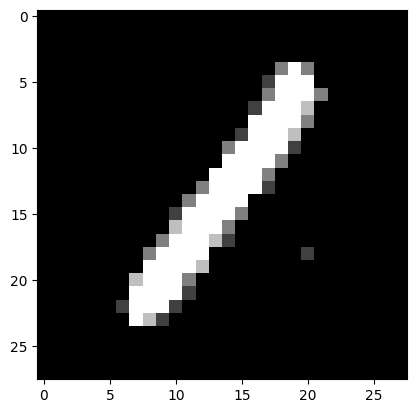

Prediction:  [3]


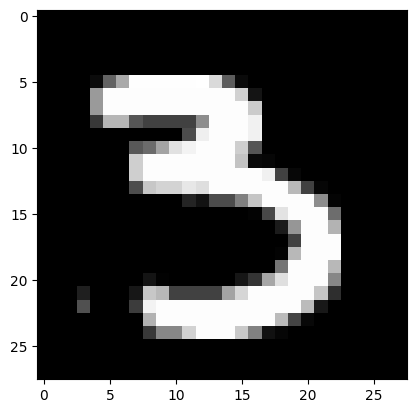

Prediction:  [3]


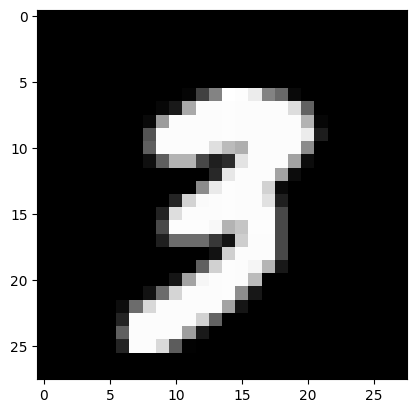

Prediction:  [6]


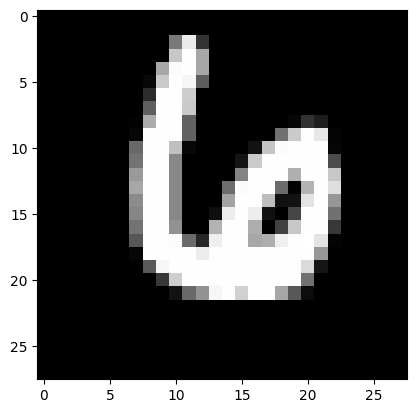

Prediction:  [5]


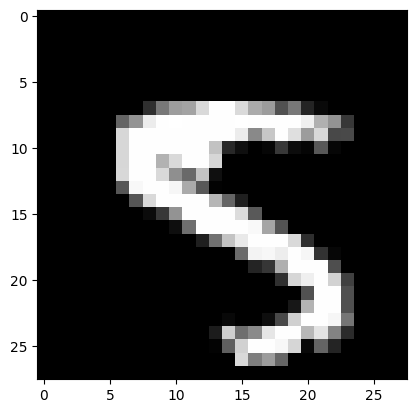

Prediction:  [0]


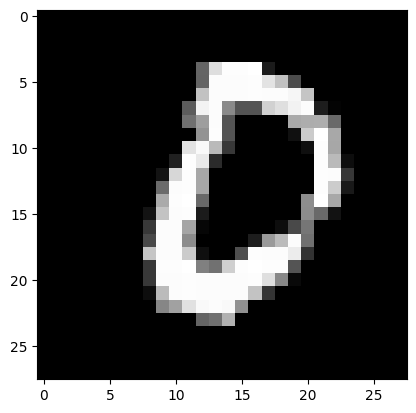

Prediction:  [8]


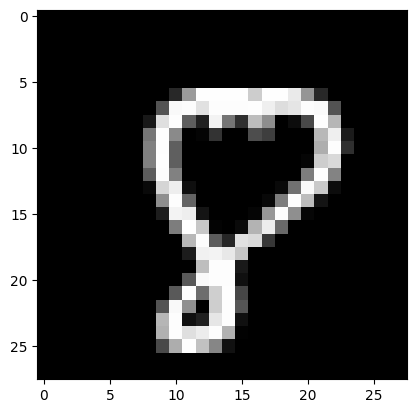

Prediction:  [1]


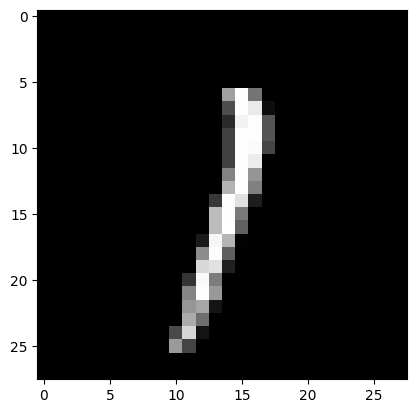

Prediction:  [0]


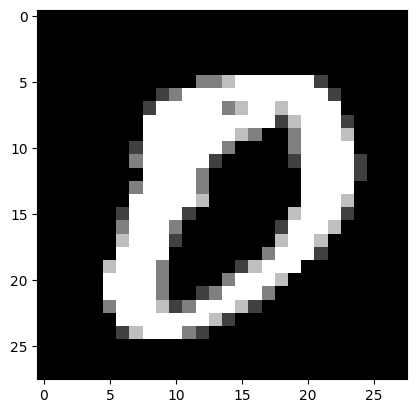

Prediction:  [6]


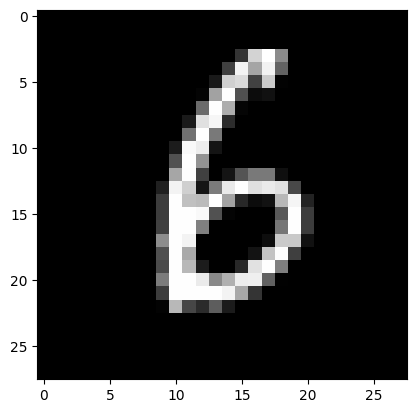

In [10]:
number_of_test = 10
for _ in range(number_of_test):
  random_index = np.random.randint(0, test_data.shape[0])
  test_plot(my_neural_network, random_index)